# Set Up

You can either run this notebook on Jupyter or in google colab. Due to the slightly different file structure after uploading to colab, the import sections have two options: one for Jupyter Notebooks and one for Google Colab. Only run the version for whichever you are using. Otherwise you will get a 'ModuleNotFoundError' error.

***

## Jupyter Notebook

Make sure you are running this in a virtual environment! Otherwise you may cause problems to your main device. 

Look up how to create a virtual environment if you don't know how.

Then in your virtual environment run the following lines:

***

pip install jupyter

pip install ipykernel

python -m ipykernel install --user --name=myenv --display-name "Python (myenv)"

pip install tensorflow

pip install shap

***

The lines will install different packages and libraries that you need for this notebook. I may have forgotten some in which case you can likely just pip install "name of package" in the same format as above.

Also, make sure to download all the files called here and every file in the 'data_files_for_data_construction' folder. Ideally you just download the whole github, but some of the CSV files are rather large.

***

## Google Colab

For colab you need to clone the github in your colab file.

In [ ]:
# Only run if using Google Colab
!git clone https://github.com/austineamonn/SummerResearch2024

## Import Standard Libraries

Before we begin we have some standard python libraries to import that we will use throughout this notebook.

In [1]:
import pandas as pd
import time

# Data Generation and Preprocessing

Before we can begin comparing privatization methods we have to generate, preprocess and privatize the data.

## Synthetic Data Generation

There was no existing dataset that contained the data needed for this project. Thus first we must generate a synthetic dataset. The dataset will be generated based on a variety of real data, mappings between datasets, and artificially generated lists. 

First we import the Data class which contains all the data needed to generate the synthetic dataset.

Next we import the DataGenerator class for the CPU. Note that a version does exist that runs on the GPU.

In [2]:
# Run this for Jupyter Notebook
from datafiles_for_data_construction.data import Data
from data_generation.data_generation_CPU import DataGenerator

In [ ]:
# Run this for Google Colab
from SummerResearch2024.datafiles_for_data_construction.data import Data
from SummerResearch2024.data_generation.data_generation_CPU import DataGenerator

Next, we instantiate the Data and DataGenerator classes. The Data class allows us to access all the data needed to generate the synthetic dataset and the DataGenerator class allows us to use the functions needed to generate the synthetic dataset.

In [3]:
data = Data()
data_generator = DataGenerator(data)

What does the data look like? Some of the data is a list of values. Some lists were generated synthetically, others were pulled from various sources. More information can be found in the README file. Here is a list of learning styles:

In [4]:
data.learning_style()["learning_style_list"]

['Visual', 'Auditory', 'Read/Write', 'Kinesthetic']

Some of the data is a dictionary. Some dictionaries map different lists together while others map lists to demographic statistics on how common each item is. This dictionary maps the learning styles to the percentage of people that have said style.

In [5]:
data.learning_style()["learning_style"]

{'Visual': 27.27, 'Auditory': 23.56, 'Read/Write': 21.16, 'Kinesthetic': 28.01}

Now we use the generate_synthetic_dataset function to create a dataset from all the data. This function has two inputs:
- number of samples (an integer) which tell the function how many 'students' we want in our dataset
- batch size (an integer) which tells the function how to split up the work to prevent overloading the computer.
You can change the values if you want to generate more or less data. Be careful as higher values for number of samples will lead to a longer runtime.

In [6]:
num_samples = 100 # You can change these values if you want
batch_size = 10 # Batch size should be about 1/10 of the number of samples

Now we call the function. Use the time library to see how long the generator takes.

In [7]:
start_time = time.time()
synthetic_data = data_generator.generate_synthetic_dataset(num_samples, batch_size)
end_time = time.time()
runtime = end_time - start_time
print(runtime)

14.826297044754028


'generate_synthetic_dataset' outputs a pandas dataframe. Let's examine closely the file dataframe structure.

In [8]:
synthetic_data.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   first name                  100 non-null    object 
 1   last name                   100 non-null    object 
 2   ethnoracial group           100 non-null    object 
 3   gender                      100 non-null    object 
 4   international status        100 non-null    object 
 5   socioeconomic status        100 non-null    object 
 6   learning style              100 non-null    object 
 7   gpa                         92 non-null     float64
 8   student semester            100 non-null    int64  
 9   major                       100 non-null    object 
 10  previous courses            100 non-null    object 
 11  course types                100 non-null    object 
 12  course subjects             100 non-null    object 
 13  subjects of interest        100 non-

Let's look at the top 5 elements of the dataframe. You can look back at the README file to get a better sense of what each column contains and how it was generated.

In [9]:
synthetic_data.head(n=5) # Change n to larger numbers to see more rows of the dataframe

,first name,last name,ethnoracial group,gender,international status,socioeconomic status,learning style,gpa,student semester,major,previous courses,course types,course subjects,subjects of interest,extracurricular activities,career aspirations,future topics
0,Meilin,Kelzenberg,European American or white,Nonbinary,Domestic,In poverty,[Auditory],3.82,8,"[Business Economics, General Business]","[Elementary French I, Undergraduate Open Semin...","[[Studio], [Laboratory-Discussion, Online], [L...","[HDFS, PS, ACE, AE, ME, NRES, PHYS, DTX, CHEM,...","[Comparative World Literature, Aerospace Engin...","[Computer Science Club, Finance Club, Marketin...","[Financial Manager, Personal Financial Advisor...","[Economics, Business Administration, Business,..."
1,Culley,Josef,African American or Black,Male,Domestic,In poverty,[Auditory],2.10,6,[Communications],"[Intro to Human Development, Writing and Resea...","[[Laboratory], [Online], [Discussion/Recitatio...","[TAM, HDFS, PHIL, EDUC, PS, ACCY, BTW, MUSC, P...","[Human Development and Family Studies, Kinesio...","[Communications Club, Media Club, Broadcasting...",[Broadcast and Sound Engineering Technician an...,"[Political Science, Marketing, Journalism, Lin..."
2,Londynn,Mus,African American or Black,Female,Domestic,In poverty,[Kinesthetic],2.76,4,[Psychology],"[Individual and Dual Activities, Undergraduate...","[[Lecture-Discussion, Online], [Lecture-Discus...","[ATMS, LAS, BTW, AFRO, PHYS, CHLH, EDUC, FAA, ...","[Physics, Astronomy, Atmospheric Sciences, Psy...","[Student Government Association, Psychology Cl...","[Counselor, Clinical Laboratory Technologist a...","[Cognitive Science, Psychology, Counseling Psy..."
3,Anjeli,Khattab,European American or white,Female,Domestic,Lower-middle income,[Auditory],2.74,10,[Nursing],"[Undergraduate Open Seminar, Organismal and Ev...","[[Lecture, Laboratory-Discussion], [Lecture, P...","[LLS, GGIS, PHIL, SPAN, FSHN, AE, MCB, KIN, AA...","[Medicine, Business, Nursing]","[Nursing Students Association, Health Administ...","[Registered Nurse, Nursing, Psychiatric, and H...","[Medicine, Biomedical Engineering, Biology, Ne..."
4,Alyse,Bytheway,European American or white,Female,Domestic,Near poverty,[Visual],2.12,12,"[Miscellaneous Social Sciences, Secondary Teac...","[Public Speaking, DGS Honors Seminar, Stars an...","[[Lecture-Discussion, Lecture], [Laboratory], ...","[LAS, BIOC, ADV, JAPN, SPAN, PS, ACE, ECON, HI...","[Education, Special Education, History, Gender...","[Social Sciences Club, Education Society, Soro...","[Childcare Worker, Postsecondary Teacher, Pres...","[Psychology, Education, Social Sciences, Human..."


## Data Preprocessing

Notice that we have columns that are lists and columns that are strings. Machine learning models need the input data to be numerical. Thus some data preprocessing is required.

We import the Preprocessing class to do the preprocessing work.

In [10]:
# Run this for Jupyter Notebook
from data_preprocessing.preprocessing import PreProcessing

In [ ]:
# Run this for Google Colab
from SummerResearch2024.data_preprocessing.preprocessing import PreProcessing

Inside the Preprocessing class there are two functions that do the main preprocessing work:
- 'stringlist_to_binarylist': converts lists of strings into a binary list
- 'string_list_to_numberedlist': converts lits of strings into a numbered list.

Imagine the full options available are ['alice', 'bob', 'charlie']
Thus for the entry ['alice', 'charlie'] we get:
[1,0,1] for 'stringlist_to_binarylist'
[0,2] for 'string_list_to_numberedlist'

When we instantiate the class and call the 'preprocess_dataset' function both of the above functions will be called on certain columns. 'stringlist_to_binarylist' is called on 'learning styles' and 'string_list_to_numberedlist' is called on all the other lists.

In [11]:
preprocessor = PreProcessing(data)
start_time = time.time()
preprocessed_data = preprocessor.preprocess_dataset(synthetic_data)
end_time = time.time()
runtime = end_time - start_time
print(runtime)

0.11820602416992188


'preprocess_dataset' outputs a pandas dataframe. Let's examine closely the file dataframe structure to see how it has changed after preprocessing.

In [12]:
preprocessed_data.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 11 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   learning style              100 non-null    object 
 1   gpa                         92 non-null     float64
 2   student semester            100 non-null    int64  
 3   major                       100 non-null    object 
 4   previous courses            100 non-null    object 
 5   course types                100 non-null    object 
 6   course subjects             100 non-null    object 
 7   subjects of interest        100 non-null    object 
 8   extracurricular activities  100 non-null    object 
 9   career aspirations          100 non-null    object 
 10  future topics               100 non-null    object 
dtypes: float64(1), int64(1), object(9)
memory usage: 8.7+ KB


Now let's look at the top 5 elements of the dataframe.

In [13]:
preprocessed_data.head(n=5) # Change n to larger numbers to see more rows of the dataframe

,learning style,gpa,student semester,major,previous courses,course types,course subjects,subjects of interest,extracurricular activities,career aspirations,future topics
0,"[0, 1, 0, 0]",3.82,8,"[21, 70]","[1009, 3338, 3339, 1923, 3338, 1884, 2199, 872...","[0, 4, 5, 10, 1, 2, 3, 7, 6, 14, 17, 15]","[98, 228, 3, 6, 132, 216, 147, 62, 46, 18, 123...","[55, 36, 9, 21, 34]","[70, 96, 67, 64, 60, 112, 75, 170, 221, 74]","[56, 104, 33, 0, 62, 95, 125, 17, 2, 98, 128, ...","[47, 27, 26, 68, 107]"
1,"[0, 1, 0, 0]",2.10,6,[31],"[1773, 3461, 3309, 3104, 3338, 1871, 3127, 192...","[0, 5, 1, 2, 3, 6, 20, 17]","[207, 98, 146, 67, 228, 2, 39, 138, 147, 206, ...","[77, 31, 72, 23, 8]","[89, 88, 41, 73, 206, 74, 67]","[18, 69, 116, 136, 83, 137, 82]","[132, 107, 92, 103, 111]"
2,"[0, 0, 0, 1]",2.76,4,[152],"[1594, 3338, 1158, 1821, 606, 3386, 1352, 3352...","[0, 5, 1, 2, 3, 11, 17]","[29, 117, 39, 8, 147, 48, 67, 82, 102, 105, 10...","[0, 17, 47, 10]","[58, 32, 63, 82]","[38, 30, 144, 67, 16, 12]","[33, 169, 171, 148, 48]"
3,"[0, 1, 0, 0]",2.74,10,[135],"[3338, 2370, 1861, 1884, 816, 606, 1516, 1668,...","[9, 0, 4, 5, 10, 1, 2, 3, 6, 18, 20]","[125, 90, 146, 158, 86, 6, 129, 114, 0, 71, 21...","[19, 21, 125]","[6, 114, 63, 123, 82, 68, 70, 96]","[122, 97, 90, 67, 16, 32, 66, 110]","[114, 24, 25, 122, 134]"
4,"[1, 0, 0, 0]",2.12,12,"[125, 157]","[2615, 790, 3029, 2956, 1923, 1959, 1811, 2371...","[9, 0, 4, 5, 10, 1, 2, 3, 7, 20, 17]","[117, 35, 5, 111, 158, 228, 3, 65, 100, 132, 1...","[22, 107, 4, 72, 8, 3]","[107, 71, 9, 260, 99, 114, 120, 69, 44, 73, 15]","[26, 112, 114, 50, 142, 136, 138, 66, 130, 101...","[169, 48, 191, 86, 223]"


## Data Privatization

Now that the data has been preprocessed we must privatize the data to keep it safe.

We import the Privatizer class to do this.

In [14]:
# Run this for Jupyter Notebook
from data_privatization.privatization import Privatizer

In [ ]:
# Run this for Google Colab
from SummerResearch2024.data_privatization.privatization import Privatizer

There are a variety of privatization methods you can try:
- Basic Differential Privacy (laplace noise addition)
- Uniform Noise Differential Privacy (uniform noise addition)
- Shuffling
Both Differential Privacy types can be done with or without list lengthening. This means the list columns like 'previous courses' could be lengthened according to the noise addition function. More details can be found in the README file. Let's try basic differential privacy with list lengthening.

In [15]:
privatization_type = 'basic differential privacy'
# Other 'privatization_type' options: 'uniform', 'shuffle', 'full shuffle' (full shuffle shuffles all of the rows)
privatizer = Privatizer(data, style=privatization_type, list_length=True)
# Can set 'list_length' to false if you don't want to allow the list sizes to change

Now we call 'privatize_dataset'. Use the time library to see how long the privatizer takes.

In [16]:
start_time = time.time()
privatized_data = privatizer.privatize_dataset(preprocessed_data)
end_time = time.time()
runtime = end_time - start_time
print(runtime)

0.021271705627441406


'privatize_dataset' outputs a pandas dataframe. Let's see how the file has changed after privatization.

In [17]:
privatized_data.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 9 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   learning style              100 non-null    object 
 1   gpa                         92 non-null     float64
 2   student semester            100 non-null    int64  
 3   major                       100 non-null    object 
 4   previous courses            100 non-null    object 
 5   course types                100 non-null    object 
 6   course subjects             100 non-null    object 
 7   subjects of interest        100 non-null    object 
 8   extracurricular activities  100 non-null    object 
dtypes: float64(1), int64(1), object(7)
memory usage: 7.2+ KB


Now let's look at the top 5 elements of the dataframe.

In [18]:
privatized_data.head(n=5) # Change n to larger numbers to see more rows of the dataframe

,learning style,gpa,student semester,major,previous courses,course types,course subjects,subjects of interest,extracurricular activities
0,"[0, 0, 1, 1]",2.06,3,"[142, 40]","[1999, 1222, 1690, 1169, 710, 1001, 2422, 1291...","[17, 10, 19, 11, 1, 11, 6, 1, 15, 6, 4, 5, 21,...","[175, 52, 54, 178, 144, 110, 154, 162, 109, 16...","[59, 95]","[196, 298, 290]"
1,"[0, 1, 0, 0]",2.55,13,[],"[1549, 2644, 295, 2219, 1567, 972, 2211, 1516,...","[6, 20, 16, 13, 8, 18, 1, 14]","[31, 9, 23, 2, 197, 93, 202, 181]","[76, 12, 37, 55, 112, 39, 91, 71, 17, 83, 88, ...","[296, 167, 47, 89, 248, 283]"
2,"[0, 0, 1, 1]",2.95,2,[],"[2191, 1323, 541, 2341, 2341, 1994, 1488, 369,...","[11, 5, 14, 17, 4, 7]","[25, 127, 119, 154, 166, 5, 135, 100, 79, 75, ...","[126, 85, 128, 141, 51, 47, 107, 88, 123, 52, ...","[39, 264, 239, 275]"
3,"[1, 0, 0, 1]",2.25,10,[97],"[2706, 498, 1359, 1520, 2094, 2580, 3262, 637]","[1, 20, 8, 20, 20, 7, 13]","[80, 150, 99, 75, 25, 52, 121, 87, 183, 77, 94...","[6, 120, 110, 37, 67, 10, 38, 78, 54, 99, 112,...","[272, 40, 25, 53, 254, 259, 276, 133, 19, 71, ..."
4,"[0, 0, 1, 0]",2.90,6,[159],"[170, 1312, 1281, 2299, 2954, 257, 3055, 1683,...","[1, 11, 12, 10, 1, 17, 15, 5, 19, 17, 14]","[106, 69, 187, 183, 120, 4, 179, 190, 185, 213...","[108, 37, 14, 6, 122, 128, 134, 77, 88, 16, 10...",[]


## Dimensionality Reduction

We still have the problem of long lists. The 'previous courses list' can be over 30 elements long! Thus we call a new function from the Preprocessor class, 'create_RNN_models'. Three different recurrent neural network models are used to reduce the dimension of each list to 1 element. The three networks are: Simple, GRU (Gated Recurrent Units), and LSTM (Long Term Short Memory).

Since 'create_RNN_models' takes in a dataframe, there is no need to create a new instance of the Preprocessor class. Thus we should call:
- 'privatized_data': reduce dimensionality
- 'preprocessed_data': give a null for comparison at the end
- 'preprocessed_data' with 'utility=True': reduce dimensionality of the utility columns

Let's also calculate and compare the runtimes. This will likely be the longest runtime taking 9 to 10 minutes.

Let us just use the simple RNN dimensionality reduction. Though this can be switch by changing 'simple' to False and a different method to True.

In [19]:
# Only let one of simple, LSTM, and GRU be equal to true.

start_time = time.time()
privatized_data_reduced = preprocessor.create_RNN_models(privatized_data, simple=True, LSTM=False, GRU=False)
end_time = time.time()
runtime_pd = end_time - start_time

start_time = time.time()
nonprivatized_data_reduced = preprocessor.create_RNN_models(preprocessed_data, simple=True, LSTM=False, GRU=False)
end_time = time.time()
runtime_npd = end_time - start_time

start_time = time.time()
utility_cols_reduced = preprocessor.create_RNN_models(preprocessed_data, utility=True, simple=True, LSTM=False, GRU=False)
end_time = time.time()
runtime_uc = end_time - start_time

print(f'Privatized data runtime: {runtime_pd}')
print(f'Nonprivatized data runtime: {runtime_npd}')
print(f'Utility columns runtime: {runtime_uc}')

Epoch 1/10


2024-07-15 01:44:19.320069: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2
2024-07-15 01:44:19.320104: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2024-07-15 01:44:19.320117: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2024-07-15 01:44:19.320368: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-07-15 01:44:19.320403: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2024-07-15 01:44:20.006827: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 74ms/step - loss: 0.2755
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0918
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.1224
Epoch 4/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0997
Epoch 5/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0832
Epoch 6/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0894
Epoch 7/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0958
Epoch 8/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0912
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Epoch 1/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.2782
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.1215
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0953
Epoch 4/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.1006
Epoch 5/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0743
Epoch 6/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0645
Epoch 7/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0659
Epoch 8/10
4/

2024-07-15 01:45:35,570 - tensorflow - WARNING - 5 out of the last 9 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x31be484a0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step

2024-07-15 01:45:36,068 - tensorflow - WARNING - 6 out of the last 12 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x31be484a0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 166ms/step
Epoch 1/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 287ms/step - loss: 0.3708
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 267ms/step - loss: 0.0720
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 259ms/step - loss: 0.0770
Epoch 4/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 254ms/step - loss: 0.0532
Epoch 5/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 255ms/step - loss: 0.0542
Epoch 6/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 254ms/step - loss: 0.0494
Epoch 7/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 263ms/step - loss: 0.0423
Epoch 8/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 259ms/step - loss: 0.0359
Epoch 9/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 263ms/step - loss: 0.0373
Epoch 10/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 262ms/step - loss: 0.0269
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
Epoch 1/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 8s 2s/step - loss: 0.3406
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - loss: 0.1324
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - loss: 0.0509
Epoch 4/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - loss: 0.0633
Epoch 5/10
4/4 ━━━━━━━━━

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 180ms/step - loss: 0.0808
Epoch 9/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 178ms/step - loss: 0.0768
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
Epoch 1/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - loss: 0.2585 
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - loss: 0.0729
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 994ms/step - loss: 0.0855
Epoch 4/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 959ms/step - loss: 0.0536
Epoch 5/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 995ms/step - loss: 0.0492
Epoch 6/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - loss: 0.0370   
Epoch 7/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 968ms/step - loss: 0.0404
Epoch 8/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 964ms/step - loss: 0.0315
Epoch 9/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 963ms/step - loss: 0.0310
Epoch 10/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 991ms/step - loss: 0.0237
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 124ms/step
Epoch 1/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 624ms/step - loss: 0.2288
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 630ms/step - loss: 0.1160
Epoch 3/10
4/4 ━━━━━━━━━━━━━

Since this code can be run to produce many dataframes the output is a list. We only made one dataframe so let's just take the first element from the list.

In [20]:
privatized_data_reduced = privatized_data_reduced[0]

nonprivatized_data_reduced = nonprivatized_data_reduced[0]

utility_cols_reduced = utility_cols_reduced[0]

'create_RNN_models' outputs a pandas dataframe. Let's look at how the file structure has changed.

In [21]:
print(privatized_data_reduced.info(verbose=True))
print(nonprivatized_data_reduced.info(verbose=True))
print(utility_cols_reduced.info(verbose=True))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 9 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   learning style              100 non-null    object 
 1   gpa                         92 non-null     float64
 2   student semester            100 non-null    int64  
 3   major                       100 non-null    object 
 4   previous courses            100 non-null    object 
 5   course types                100 non-null    object 
 6   course subjects             100 non-null    object 
 7   subjects of interest        100 non-null    object 
 8   extracurricular activities  100 non-null    object 
dtypes: float64(1), int64(1), object(7)
memory usage: 7.2+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 11 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      ---------

Now let's look at the top 5 elements for each of the dataframes

In [22]:
print(privatized_data_reduced.head(n=5))
print(nonprivatized_data_reduced.head(n=5))
print(utility_cols_reduced.head(n=5))
# Change n to larger numbers to see more rows of the dataframe

  learning style   gpa  student semester         major previous courses  \
0   [0.58496344]  2.06                 3   [0.7224096]     [0.32464004]   
1   [0.43817008]  2.55                13  [0.47883472]      [0.2929188]   
2   [0.58496344]  2.95                 2  [0.47883472]     [0.55412436]   
3   [0.33920488]  2.25                10   [0.5707858]     [0.40311542]   
4    [0.6112428]  2.90                 6  [0.45509797]     [0.29271233]   

   course types course subjects subjects of interest  \
0  [0.12526418]    [0.74721223]         [0.47287908]   
1     [0.49262]    [0.46803603]         [0.42100683]   
2   [0.5755037]    [0.23035413]          [0.2658194]   
3   [0.5276904]    [0.44768062]         [0.83441377]   
4  [0.39458588]     [0.4886636]          [0.8480801]   

  extracurricular activities  
0                [0.5219876]  
1                [0.4513868]  
2               [0.43379772]  
3               [0.36344242]  
4               [0.49059412]  
  learning style   gpa  st

## Combining Preprocessed Data

Now we have to preprocess the private columns so that machine learning models can train on them. To do this we import the PrivateColumns from the 'preprocessing_private_columns' file.

In [23]:
# Run this for Jupyter Notebook
from data_preprocessing.processing_private_columns import PrivateColumns

In [ ]:
# Run this for Google Colab
from SummerResearch2024.data_preprocessing.processing_private_columns import PrivateColumns

Now we can instantiate the class.

In [24]:
private_columns_data = PrivateColumns(data)

Get the privacy columns from the nonprivatized dataset as we only need them once.

In [25]:
privacy_columns = private_columns_data.get_private_cols(synthetic_data)

Now we use pandas to combine back together the feature columns, the private columns, and the utility columns. We do this for both the privatized and nonprivatized dataset

In [26]:
privatized_combined = pd.concat([privatized_data_reduced, utility_cols_reduced, privacy_columns])
nonprivatized_combined = pd.concat([nonprivatized_data_reduced, utility_cols_reduced, privacy_columns])

Let us examine the file structure of these new combined datasets.

In [27]:
print(privatized_combined.info(verbose=True))
print(nonprivatized_combined.info(verbose=True))

<class 'pandas.core.frame.DataFrame'>
Index: 300 entries, 0 to 99
Data columns (total 15 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   learning style              200 non-null    object 
 1   gpa                         184 non-null    float64
 2   student semester            200 non-null    float64
 3   major                       200 non-null    object 
 4   previous courses            200 non-null    object 
 5   course types                200 non-null    object 
 6   course subjects             200 non-null    object 
 7   subjects of interest        200 non-null    object 
 8   extracurricular activities  200 non-null    object 
 9   career aspirations          100 non-null    object 
 10  future topics               100 non-null    object 
 11  ethnoracial group           100 non-null    object 
 12  gender                      100 non-null    object 
 13  international status        100 non-null 

Let's look at the top five elements of both the combined dataframes.

In [28]:
print(privatized_combined.head(n=5))
print(nonprivatized_combined.head(n=5))
# Change n to larger numbers to see more rows of the dataframe

  learning style   gpa  student semester         major previous courses  \
0   [0.58496344]  2.06               3.0   [0.7224096]     [0.32464004]   
1   [0.43817008]  2.55              13.0  [0.47883472]      [0.2929188]   
2   [0.58496344]  2.95               2.0  [0.47883472]     [0.55412436]   
3   [0.33920488]  2.25              10.0   [0.5707858]     [0.40311542]   
4    [0.6112428]  2.90               6.0  [0.45509797]     [0.29271233]   

   course types course subjects subjects of interest  \
0  [0.12526418]    [0.74721223]         [0.47287908]   
1     [0.49262]    [0.46803603]         [0.42100683]   
2   [0.5755037]    [0.23035413]          [0.2658194]   
3   [0.5276904]    [0.44768062]         [0.83441377]   
4  [0.39458588]     [0.4886636]          [0.8480801]   

  extracurricular activities career aspirations future topics  \
0                [0.5219876]                NaN           NaN   
1                [0.4513868]                NaN           NaN   
2               [

# Utility - Privacy Tradeoff Tests

Now that we have our combined datasets we are ready to begin testing!

***

The reason for balancing the data privatization is to maximize the utility of the dataset while minimizing the privacy loss of the dataset. Perfectly private data would have no utility and vice versa.

Since our private columns are distinct classes, the privacy loss will be measured with accuracy where we want a low accuracy to keep the data safe. Meanwhile, after the RNNs our utility columns are essentially continuous. Thus utility gain will be measured with error where we want a low error to keep the data useful.

## Decision Tree Classifier

Our first test for this is the classifier decision tree. Since it is a classifier we will be using it to test privacy loss for the private columns. Import the DTClassifier class from 'decision_tree_classifier'.

In [29]:
# Run this for Jupyter Notebook
from calculating_tradeoffs.classification.decision_tree_classifier.decision_tree_classifier import DTClassifier

In [ ]:
# Run this for Google Colab
from SummerResearch2024.calculating_tradeoffs.classification.decision_tree_classifier.decision_tree_classifier import DTClassifier

First we instantiate 2 classes. One for the privatized data and one for the non privatized data. We will only run them for the 'Simple1' RNN model to keep things simple. Ba Dum Tss! Similarly we will only look at the 'ethnoracial group' target.

In [30]:
RNN_model = 'Simple1' # You can change it to 'GRU1' or 'LSTM1' if you used a different RNN model
target = 'ethnoracial group' # You can change it to 'gender', 'international status', or 'socioeconomic status' if you like
privatization_type = 'Basic_DP' # You can change it to 'Basic_DP_LLC', 'Uniform', 'Uniform_LLC', 'Shuffling', or 'Complete_Shuffling' if you used a different privatization model

private_classifier = DTClassifier(privatization_type, RNN_model, target, privatized_combined)

Now that we have instantiated the class we need to find the best model. We will use a metric called cost complexity pruning to decide how to prune our tree to prevent overfitting.

In [31]:
best_model, ccp_alpha = private_classifier.get_best_model(make_graphs=False, save_model=False) # Leave this input to prevent the graphs from being produced
print(best_model)

DecisionTreeClassifier(random_state=0)


What does this best model look like? Let's print out the decision tree to see for ourselves.

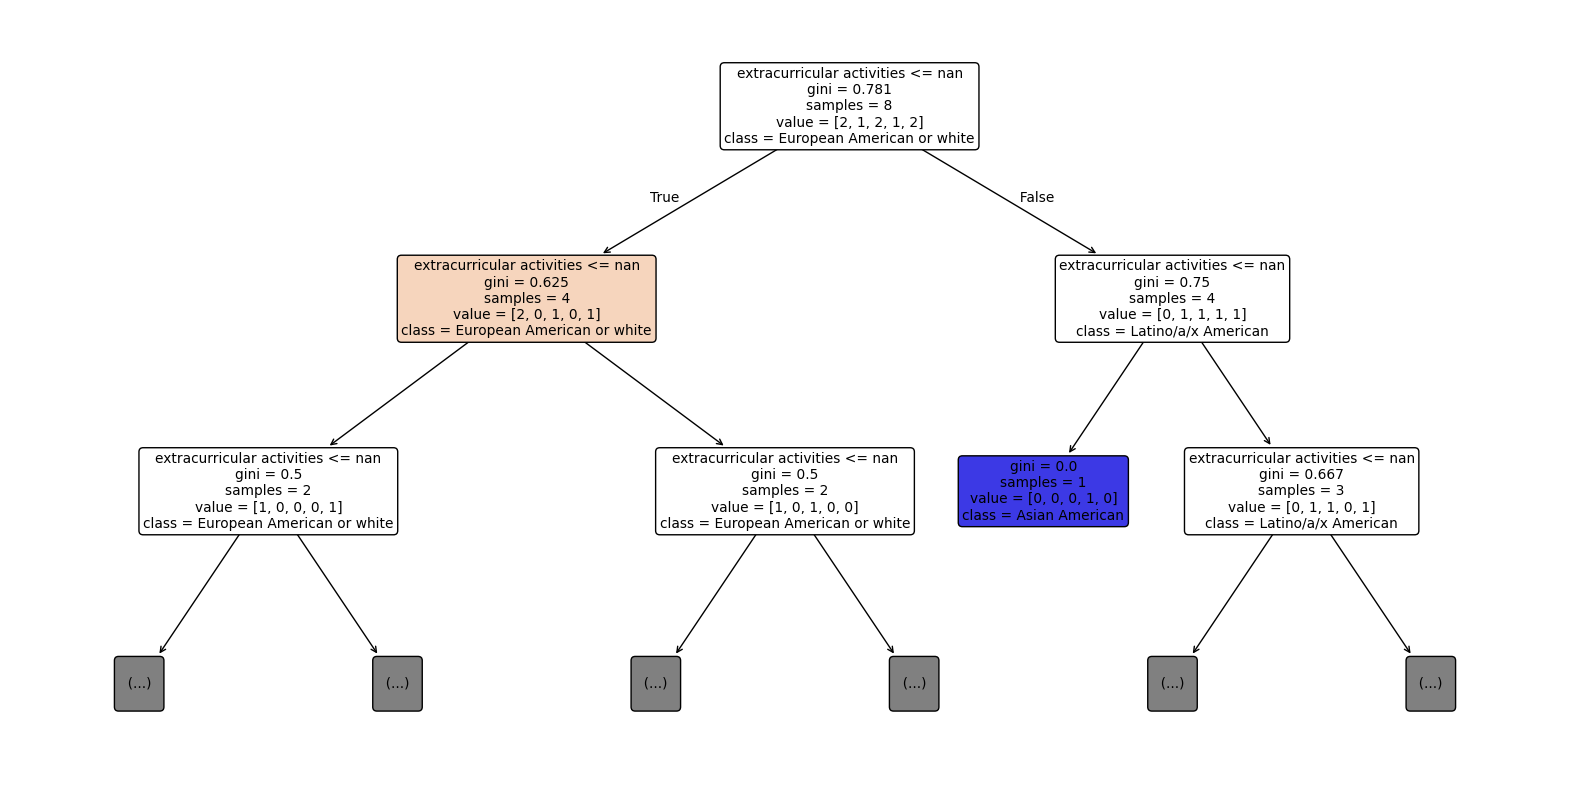

In [32]:
private_classifier.plotter(model=best_model, show_fig=True)

Now that we have the best ccp alpha let us run that model and get the classification report.

In [33]:
private_classifier.run_model(ccp_alpha=ccp_alpha, print_report=True, save_files=False, plot_files=False, get_shap=False) # Leave as is to prevent the graphs from being produced

                                  precision    recall  f1-score   support

      European American or white       0.00      0.00      0.00       0.0
             Latino/a/x American       0.00      0.00      0.00       1.0
       African American or Black       0.00      0.00      0.00       0.0
                  Asian American       0.00      0.00      0.00       1.0
                     Multiracial       0.00      0.00      0.00       0.0
American Indian or Alaska Native       0.00      0.00      0.00       0.0
                Pacific Islander       0.00      0.00      0.00       0.0

                        accuracy                           0.00       2.0
                       macro avg       0.00      0.00      0.00       2.0
                    weighted avg       0.00      0.00      0.00       2.0



Now let's repeat all of this for the nonprivatized dataset.

DecisionTreeClassifier(random_state=0)


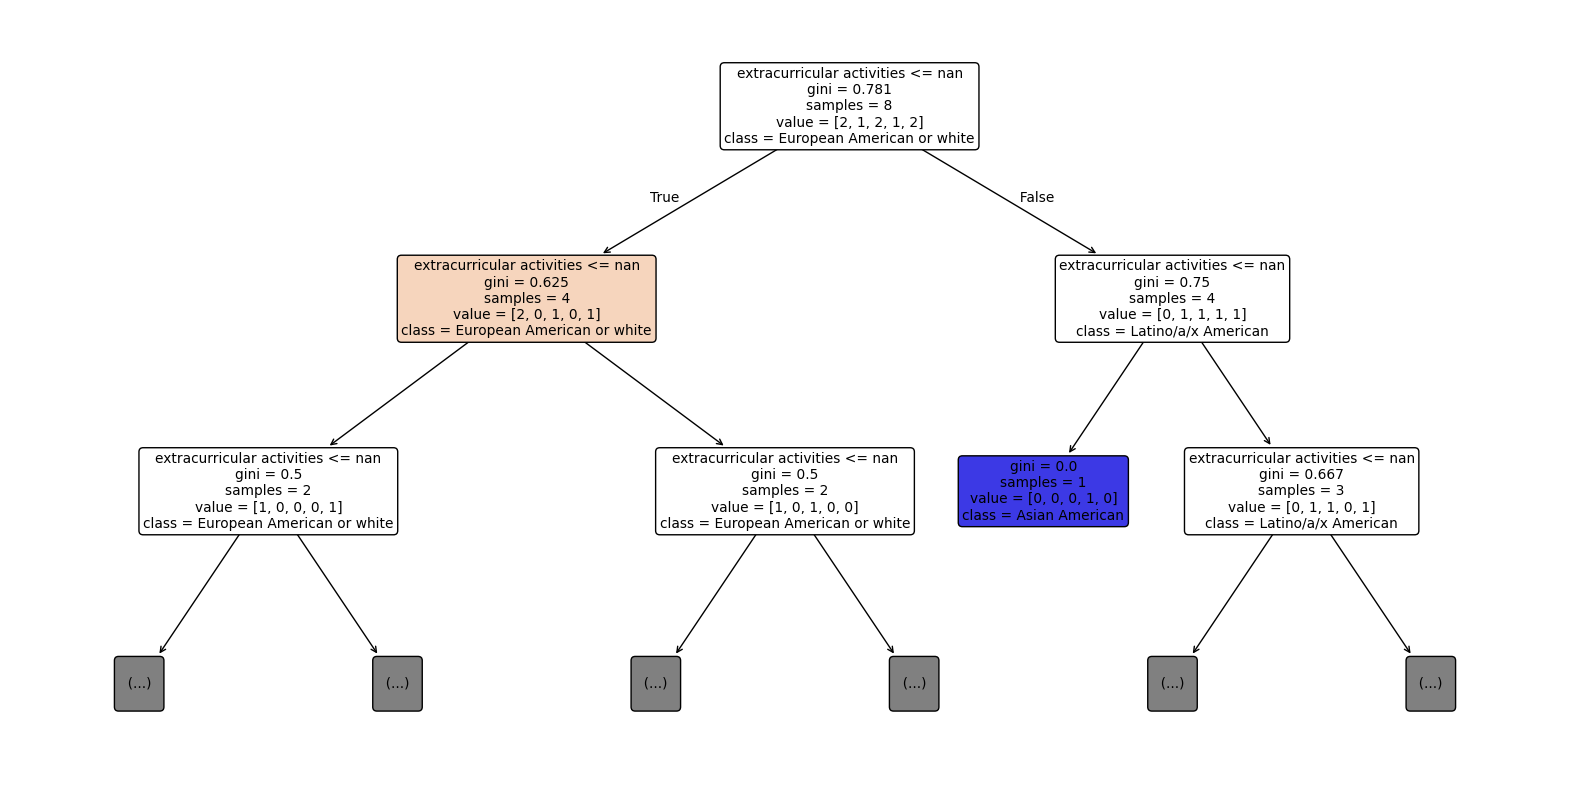

In [34]:
privatization_type = 'NoPrivatization'

nonprivate_classifier = DTClassifier(privatization_type, RNN_model, target, privatized_combined)

# Get the best ccp alpha based on X test accuracy
best_model, ccp_alpha = nonprivate_classifier.get_best_model(make_graphs=False, save_model=False) # Leave this input to prevent the graphs from being produced
print(best_model)

# Plot the best model
nonprivate_classifier.plotter(model=best_model, show_fig=True)

Now that we have the best model for the nonprivatized data, lets get the classification report for the model

In [35]:
nonprivate_classifier.run_model(ccp_alpha=ccp_alpha, print_report=True, save_files=False, plot_files=False, get_shap=False) # Leave as is to prevent the graphs from being produced

                                  precision    recall  f1-score   support

      European American or white       0.00      0.00      0.00       0.0
             Latino/a/x American       0.00      0.00      0.00       1.0
       African American or Black       0.00      0.00      0.00       0.0
                  Asian American       0.00      0.00      0.00       1.0
                     Multiracial       0.00      0.00      0.00       0.0
American Indian or Alaska Native       0.00      0.00      0.00       0.0
                Pacific Islander       0.00      0.00      0.00       0.0

                        accuracy                           0.00       2.0
                       macro avg       0.00      0.00      0.00       2.0
                    weighted avg       0.00      0.00      0.00       2.0

